# CEO-Request Challenge

## 1. Sorun Tanımının Özeti

❓ **Olist kârını nasıl artırabilir?** ❓

### P&L Kuralları

#### Revenues  (Gelirler )
**Sales fees:** Olist, teslim edilen her order’ın ürün fiyatı üzerinden (freight hariç) **%10 pay** alır.  
**Subscription fees:** Olist, seller başına ayda **80 BRL** ücret alır.

#### Costs (Maliyetler)
Kötü review’lara (<= 3 stars) sahip orders için _tahmini_ **reputation costs**  

💡 Uzun vadede kötü customer experience iş açısından sonuçlara yol açar: düşük tekrar satın alma oranı, anında customer support maliyeti, refunds veya olumsuz word of mouth iletişimi. Her kötü review için parasal bir cost varsayımı yapıyoruz:

```python
# review_score: cost(BRL)
{'1 star': 100
'2 stars': 50
'3 stars': 40
'4 stars': 0
'5 stars': 0}
```

**IT costs:** Olist'in total cumulated IT Costs değeri, platforma şimdiye kadar katılmış toplam seller sayısının karekökü ile, şimdiye kadar satılmış toplam birikimli item sayısının karekökü oranında ölçeklenir.

$IT\_costs = \alpha * \sqrt{n\_sellers} + \beta * \sqrt{n\_items}$  

Olist'in data team’i bize bu scaling parameter’ları için şu değerleri verdi:
- $\alpha = 3157.27$
- $\beta = 978.23$

💡 Yönetilen seller sayısı da, sales transaction sayısı da IT systems için maliyetlidir.
💡 Ancak karekök kullanımı scale-effects’i gösterir: IT-system’ler büyüdükçe daha verimli olma eğilimindedir.
💡 Alpha > Beta olması, Olist’in çok item satan az sayıda seller ile çalıştığında, bunun tersi senaryoya göre daha düşük IT Cost’a sahip olduğu anlamına gelir.

1000 sellers ve toplam 100 items satışıyla toplam IT cost 109,624 BRL olur

100 sellers ve toplam 1000 items satışıyla toplam IT cost 62,507 BRL olur

Son olarak, IT department size marketplace’in kuruluşundan bu yana birikmiş IT costs toplamının 500,000 BRL olduğunu da iletti.

Şimdi, bu IT cost formülünü biraz daha iyi anlamak için bir simulation çalıştıralım. Kod üzerinde zaman harcamanıza gerek yok, sadece ortaya çıkan chart’lara bakın.

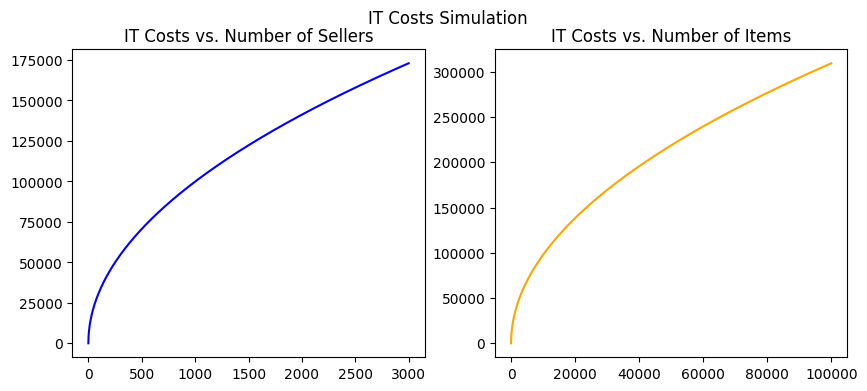

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

alpha = 3157.27
beta = 978.23

x_sellers = np.arange(3_000)
y_it_costs_sellers = alpha * x_sellers ** 0.5

x_items = np.arange(100_000)
y_it_costs_items = beta * x_items ** 0.5

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sellers, y_it_costs_sellers, label='IT costs per seller', color='blue')
plt.title('IT Costs vs. Number of Sellers')
plt.subplot(1, 2, 2)
plt.plot(x_items, y_it_costs_items, label='IT costs per item', color='orange')
plt.title('IT Costs vs. Number of Items')
plt.suptitle('IT Costs Simulation');

### Key Findings, so far

- `wait_time`, düşük review_score’ların arkasındaki en önemli faktördür.  
- `wait_time`, seller’ın `delay_to_carrier` süresi + `carrier_delivery_time` toplamından oluşur.  
- Carrier’ın delivery time’ı Olist’in doğrudan kontrolünde olmadığı için, bunu iyileştirmek hızlı kazanım sağlayacak bir öneri değildir.  
- Buna karşılık, daha iyi bir `seller` seçimi `delay_to_carrier` değerini olumlu şekilde etkileyebilir ve Olist üzerindeki kötü `review_scores` sayısını azaltabilir.  
- Kötü review’lardaki yorumlar, bazılarının seller’dan veya bizzat üründen kaynaklandığını göstermiştir.

💡 Aşağıdaki bölüm 2’deki guided seller analysis ile başlamanızı öneririz.

💪 Ancak bölüm 3 ile başka hipotezleri araştırmakta özgürsünüz.

## 2. Olist, performansları düşük satıcıları pazarından çıkarmalı mı? 🕵🏻
*(önerilen)*

Olist’in marketplace’inden en kötü seller’ları çıkarmanın etkisini analiz etmek için bir **what-if analysis** yapacağız.

👉 **Olist bu seller’ları en baştan hiç kabul etmemiş olsaydı ne olurdu?**  

*(Gerçekte, kimin iyi seller olduğunu önceden bilmek zordur, ancak bu yaklaşımla başlayıp daha sonra iterasyon yapacağız.)*


### 2.1 Veri Hazırlama

Her bir `seller_id` için, başlangıçtan itibaren kümülatif olarak hesaplayın:
- seller’ın getirdiği `revenues`
- seller’ın kötü review’larına bağlı `review_costs`
- ortaya çıkan `profits` (revenues - costs)

👉 İhtiyacınız olan DataFrame’i oluşturmak için adım adım bir strateji yazın.

⚠️ **Sıfırdan başlamayın, mevcut package’ınızı güncelleyin!** 😉

**Çözüm, notebook’a yeni kod yazmakta değil — `.py` dosyalarınızdaki kodu değiştirmektedir.**

`olist` package’ınız içindeki `Seller` class’ından başlayarak:

`get_training_data` method’unu düzenleyin; döndürdüğü DataFrame şu alanları içermeli:
- `revenues`: subscription + sales fees toplamı  
- `cost_of_reviews`: kötü review’lara bağlı toplam cost  
- `profits`: `revenues` - `cost_of_reviews`

`cost_of_reviews` için önce başka bir method’u değiştirmeniz gerekecek. Bununla ilgili olan method hangisi?

In [1]:
from olist.seller import Seller
print("get_training_data" in dir(Seller))
print([m for m in dir(Seller) if "train" in m])


True
['get_training_data']


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from olist.seller import Seller
df = Seller().get_training_data()
df[["seller_id", "revenues", "cost_of_reviews", "profits", "quantity"]].head()
df.isna().sum().sort_values(ascending=False).head(10)


/Users/emre/code/emrekayaa/data-context-and-setup/olist/seller.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delay = ship.groupby('seller_id').apply(delay_to_logistic_partner).reset_index()
/Users/emre/code/emrekayaa/data-context-and-setup/olist/seller.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wait = ship.groupby('seller_id').apply(order_wait_time).reset_index()


share_of_one_stars     5
share_of_five_stars    5
review_score           5
seller_id              0
seller_city            0
revenues               0
subscription_fees      0
sales_fees             0
cost_of_reviews        0
sales                  0
dtype: int64

In [4]:
import olist.seller
print(olist.seller.__file__)

/Users/emre/code/emrekayaa/data-context-and-setup/olist/seller.py


In [4]:
df_sorted = df.sort_values("profits", ascending=False)
df_sorted.head()


,seller_id,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,months_on_olist,n_orders,quantity,quantity_per_order,sales,review_score,share_of_five_stars,share_of_one_stars,cost_of_reviews,sales_fees,subscription_fees,revenues,profits
868,53243585a1d6dc2643021fd1853d8905,lauro de freitas,BA,0.0,13.374429,2017-08-28 18:44:58,2018-08-21 16:35:26,12.0,358,410,1.145251,222776.05,4.128141,0.525126,0.087940,4480.000000,21794.044,1040.0,22834.044,18354.044000
67,7e93a43ef30c4f03f38b393420bc753a,barueri,SP,0.0,11.335141,2016-10-08 03:19:09,2018-07-14 21:25:19,21.0,336,340,1.011905,176431.87,4.364486,0.663551,0.062305,3095.000000,16598.149,1760.0,18358.149,15263.149000
534,fa1c13f2614d7b5c4749cbc52fecda94,sumare,SP,0.0,13.341871,2017-01-07 20:55:10,2018-08-29 10:04:16,20.0,585,586,1.001709,194042.03,4.373913,0.685217,0.078261,5760.000000,19091.714,1680.0,20771.714,15011.714000
2833,46dc3b2cc0980fb8ec44634e21d2718e,rio de janeiro,RJ,0.0,11.800424,2016-10-06 15:44:00,2018-08-17 22:49:38,23.0,521,542,1.040307,128111.19,4.263566,0.643411,0.094961,5993.333333,12281.138,1920.0,14201.138,8207.804667
2506,4869f7a5dfa277a7dca6462dcf3b52b2,guariba,SP,0.0,15.005261,2017-03-07 13:04:43,2018-08-24 19:55:21,18.0,1132,1156,1.021201,229472.63,4.139474,0.599123,0.106140,16406.666667,22698.793,1520.0,24218.793,7812.126333


In [6]:
#Cumulative metrikler; “İlk N seller’ı tutsaydık, toplam ne kazanırdık?”
import numpy as np

df_sorted["cum_revenues"] = df_sorted["revenues"].cumsum()
df_sorted["cum_profits"] = df_sorted["profits"].cumsum()
df_sorted["cum_quantity"] = df_sorted["quantity"].cumsum()
df_sorted["cum_sellers"] = np.arange(1, len(df_sorted) + 1)


<Axes: title={'center': 'Cumulative Profit vs Number of Sellers'}, xlabel='cum_sellers'>

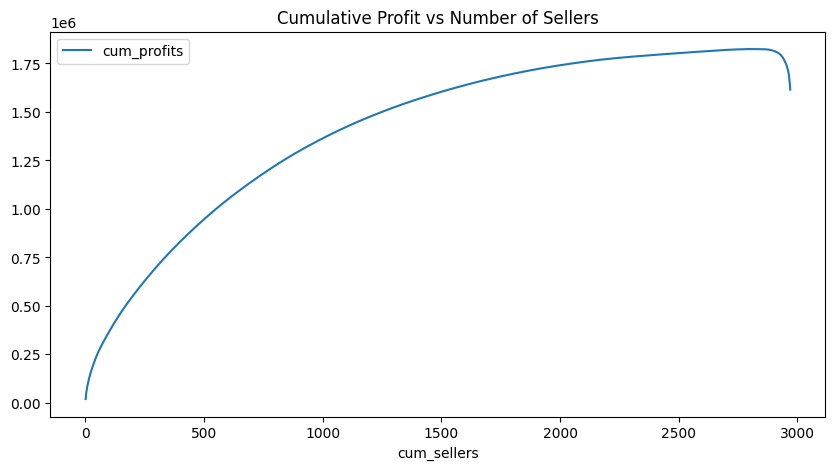

In [7]:
#grafikte görelim
df_sorted.plot(
    x="cum_sellers",
    y="cum_profits",
    figsize=(10, 5),
    title="Cumulative Profit vs Number of Sellers"
)


In [ ]:
#Grafikteki kırılma, optimum sellers sayısı


In [9]:
#Optimum Sellers' ı matematiksel olarak bulalım : yani kaç satıcı tutulursa toplam kar o kadar fazla olur ? 
optimal_idx = df_sorted["cum_profits"].idxmax()
optimal_n = df_sorted.loc[optimal_idx, "cum_sellers"]

optimal_n


np.int64(2799)

In [10]:
df_sorted[["profits"]].describe()

optimal_n

df_sorted.loc[optimal_idx, [
    "cum_sellers",
    "cum_profits",
    "cum_revenues",
    "cum_quantity"
]]

cum_sellers               2799
cum_profits     1823976.169563
cum_revenues       2646835.899
cum_quantity             75093
Name: 1167, dtype: object

### 2.2 IT Maliyetleri Hariç Varsayım Analizi

👉 Gerçek analizi yapma zamanı. İlk olarak bunu IT costs **dahil etmeden** gerçekleştireceğiz.

Adımlarımız:  

1️⃣ Sellers verisini load edin ve profits değerine göre azalan şekilde sıralayın.

2️⃣ Cumulative değerleri hesaplayın:
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için cumulative items sold hesaplayın.

   Pandas ile cumulative sum nasıl hesaplanır, araştırın.

3️⃣ Sonuçlarınızı plot edin ve analiz edin. Pandas’ın `.plot()` method’unu kullanın.

4️⃣ Profits’e göre tutulması gereken optimum seller sayısını belirleyin. (İpucu: `np.argmax` araştırın). Bu kararın etkisi ne olurdu:
   - Net profit (IT costs dahil etmediğimiz için IT costs öncesi)?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

In [11]:
df_sorted[["profits"]].describe()

optimal_n

df_sorted.loc[optimal_idx, [
    "cum_sellers",
    "cum_profits",
    "cum_revenues",
    "cum_quantity"
]]

cum_sellers               2799
cum_profits     1823976.169563
cum_revenues       2646835.899
cum_quantity             75093
Name: 1167, dtype: object

### 2.3 IT maliyetleri ile varsayımsal analiz (İsteğe bağlı)

👉 Bu kez IT costs dahil edilerek gerçek analizi yapma zamanı.

Adımlarımız şunlar:  

1️⃣ İki parametreye göre IT costs hesaplayan bir function yazın: seller sayısı ve item sayısı. Temelde matematiksel formülü Python kullanarak yazmanız yeterli.

2️⃣ Sellers verisini load edin ve (IT costs öncesi) kârlarına göre azalan şekilde sıralayın.

3️⃣ Cumulative değerleri hesaplayın (önceki kodu yeniden kullanın):
   - Her satır için cumulative revenues hesaplayın.
   - Her satır için cumulative profits hesaplayın.
   - Her satır için toplam satılan item miktarının cumulative değerini hesaplayın.  

4️⃣ IT costs etkisini hesaplayın:
   - 1️⃣. adımda yazdığınız function’ı kullanarak her satır için cumulative IT cost ekleyin.
   - IT costs sonrası net profit’i hesaplayın.

5️⃣ Sonuçlarınızı plot edin ve analiz edin.

6️⃣ Bu kez IT costs sonrası kârları baz alarak tutulması gereken optimum seller sayısını belirleyin. Bu kararın etkisi ne olurdu:
   - IT costs sonrası net profit?
   - IT costs öncesi net profit?
   - IT costs?
   - Total revenues?
   - Seller sayısı?
   - Satılan item sayısı?

Analizinizde IT costs ne kadar önemliydi?


In [12]:
import numpy as np

alpha = 3157.27
beta = 978.23

def it_cost(n_sellers, n_items):
    """
    IT costs scaling with sqrt(#sellers) and sqrt(#items)
    """
    return alpha * np.sqrt(n_sellers) + beta * np.sqrt(n_items)


In [14]:
#Seller verisini load et + profits’e göre sırala (IT öncesi)
from olist.seller import Seller

df = Seller().get_training_data()

df_sorted = df.sort_values("profits", ascending=False).reset_index(drop=True)


/Users/emre/code/emrekayaa/data-context-and-setup/olist/seller.py:42: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delay = ship.groupby('seller_id').apply(delay_to_logistic_partner).reset_index()
/Users/emre/code/emrekayaa/data-context-and-setup/olist/seller.py:45: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wait = ship.groupby('seller_id').apply(order_wait_time).reset_index()


In [15]:
#Cumulative değerleri hesaplayalım;
df_sorted["cum_revenues"] = df_sorted["revenues"].cumsum()
df_sorted["cum_profits_no_it"] = df_sorted["profits"].cumsum()
df_sorted["cum_quantity"] = df_sorted["quantity"].cumsum()
df_sorted["cum_sellers"] = np.arange(1, len(df_sorted) + 1)


In [16]:
#IT cost ekle + IT sonrası net profit hesapla
df_sorted["cum_it_cost"] = it_cost(df_sorted["cum_sellers"], df_sorted["cum_quantity"])
df_sorted["cum_net_profit_with_it"] = df_sorted["cum_profits_no_it"] - df_sorted["cum_it_cost"]


<Axes: title={'center': 'Cumulative Profit: before vs after IT costs'}, xlabel='cum_sellers'>

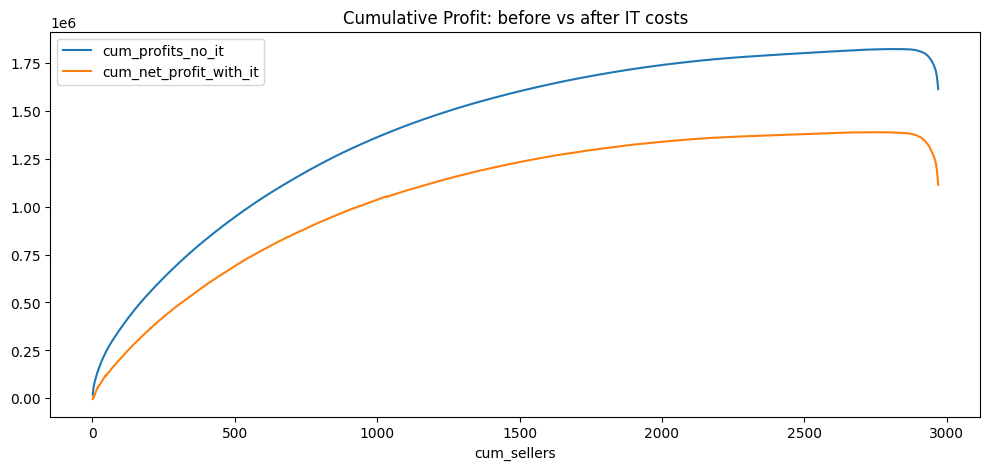

In [17]:
#Plot/Grafik IT öncesi ve Sonrası
df_sorted.plot(
    x="cum_sellers",
    y=["cum_profits_no_it", "cum_net_profit_with_it"],
    figsize=(12, 5),
    title="Cumulative Profit: before vs after IT costs"
)


In [19]:
#Optimum N’i IT sonrası net profit’e göre bul + etkileri raporla
optimal_idx_it = df_sorted["cum_net_profit_with_it"].idxmax()
optimal_row_it = df_sorted.loc[optimal_idx_it]

optimal_n_it = int(optimal_row_it["cum_sellers"])
optimal_n_it


2754

In [20]:
#Karar
summary_it = optimal_row_it[[
    "cum_sellers",
    "cum_quantity",
    "cum_revenues",
    "cum_profits_no_it",
    "cum_it_cost",
    "cum_net_profit_with_it"
]]

summary_it


cum_sellers                         2754
cum_quantity                       74688
cum_revenues                 2637319.955
cum_profits_no_it         1822601.892229
cum_it_cost                433030.512804
cum_net_profit_with_it    1389571.379425
Name: 2753, dtype: object

In [22]:
import pandas as pd
#Mevcut durumla kıyas, yani hiç kimseyi çıkarmasaydık
current_row = df_sorted.iloc[-1]

comparison = pd.DataFrame({
    "optimum_IT": summary_it,
    "current_all_sellers": current_row[[
        "cum_sellers",
        "cum_quantity",
        "cum_revenues",
        "cum_profits_no_it",
        "cum_it_cost",
        "cum_net_profit_with_it"
    ]]
})

comparison


,optimum_IT,current_all_sellers
cum_sellers,2754,2970
cum_quantity,74688,112444
cum_revenues,2637319.955,3011589.811
cum_profits_no_it,1822601.892229,1614719.811
cum_it_cost,433030.512804,500090.617368
cum_net_profit_with_it,1389571.379425,1114629.193632


When IT costs are incorporated into the analysis, the optimal number of sellers decreases slightly from 2,799 to 2,754.
In this scenario, removing 216 low-performing sellers increases net profit by approximately 275,000 BRL, despite a reduction in total revenues and sales volume.
This improvement is driven by both lower reputation-related costs and a significant reduction in IT costs, which scale with the square root of the number of sellers and items sold.
Overall, the results suggest that a more selective seller strategy—favoring quality over quantity—would improve Olist’s long-term profitability.

IT ne kadar önemliydi ? 
Çok önemliydi. Çünkü:

IT cost farkı: ~67K BRL

Net profit artışının ~%24’ü sadece IT cost azalmasından geliyor

IT cost dahil edilince:

Optimum seller sayısı 45 daha az çıktı (2799 → 2754)

Yani IT costs kararı değiştirecek kadar etkili.

## 3. Diğer Yaklaşımları Araştırın 🕵️
*(isteğe bağlı)*

- Olist, en kötü performans gösteren ürünleri/kategorileri pazarından tamamen kaldırmalı mı?
- Olist, birkaç aylık balayı döneminden sonra, sadece sürekli olarak düşük performans gösteren satıcıları kaldırmalı mı?
- Olist, satıcılardan ürün listelerine belirli bilgileri eklemelerini zorunlu kılmalı mı?
- Olist, günün belirli saatlerinde müşterilerden satın alma onayı istemeli mi?
- Olist, gecikmeleri önlemek için belirli eyaletler arasındaki satıcı/müşteri çiftlerini kısıtlamalı mı?
- Olist, bazı maliyet varsayımları önerilerek yeni satıcılar kazanmalı mı?
- ...

## Sıra Sende!

🧺 Bu defteri düzenli tutun! 

🗣 📊 Bu `Communicate`  ünitesinin sonunda, en sevdiğiniz TA'ya görüşlerinizi sunacaksınız 💪